In [154]:
import pandas as pd
import numpy as numpy
import json 
import os 
import pylab as pl
import urllib
import requests
import geopandas as gp
import shapely
from fiona.crs import from_epsg
import sklearn.preprocessing as preprocessing
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.ensemble  import GradientBoostingClassifier as gdb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.optimize import minimize
from statsmodels.graphics.api import abline_plot
import patsy
from sklearn import preprocessing
import seaborn as sns
from sklearn.ensemble  import RandomForestRegressor as rfr


%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mod', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Task 1: Collect the school related data

### importing SAT data

In [2]:
url = 'https://data.cityofnewyork.us/api/views/f9bf-2cp4/rows.csv?accessType=DOWNLOAD'

sat = pd.read_csv(url)

sat.head(3)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370


In [3]:
sat.tail(3)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
475,79M645,SCHOOL FOR COOPERATIVE TECHNICAL EDUCATION,s,s,s,s
476,79Q950,GED PLUS s CITYWIDE,8,496,400,426
477,79X490,PHOENIX ACADEMY,9,367,370,360


> looks like nan values are represented with an 's'

### create feature for average of 3 scores

#### cleaning and making colunns numeric

In [4]:
sat.replace('s', np.nan, inplace=True)
sat.tail(3)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
475,79M645,SCHOOL FOR COOPERATIVE TECHNICAL EDUCATION,NaN,NaN,NaN,NaN
476,79Q950,GED PLUS s CITYWIDE,8,496,400,426
477,79X490,PHOENIX ACADEMY,9,367,370,360


> checking out how many nans i have

In [5]:
sat.shape

(478, 6)

In [6]:
#found this trick on stack overflow: https://stackoverflow.com/questions/14247586/python-pandas-how-to-select-rows-with-one-or-more-nulls-from-a-dataframe-without
#its my new favorite function 

nans = lambda sat: sat[sat.isnull().any(axis=1)]
nans(sat).shape

(57, 6)

> by dropping nans i will lose the 12% of the schools in the dataset with no SAT information available. the purpose of this project is to explore the relationship between enrivonmnental factors and SAT scores, so i cannot do this for schools with no SAT scores. That said, the fact that there are no scores for some schools may be valuable in some sense- not having students take the SATs or not reporting SAT scores may say something about the school. I will remove nans anyway to simplify the analysis. Further research should return to these schools without scores to explore. 

In [7]:
sat.dropna(inplace=True)
sat.shape

(421, 6)

In [8]:
sat['read_avg'] = pd.to_numeric(sat['SAT Critical Reading Avg. Score'])
sat['math_avg'] = pd.to_numeric(sat['SAT Math Avg. Score'])
sat['write_avg'] = pd.to_numeric(sat['SAT Writing Avg. Score'])
sat['n'] = pd.to_numeric(sat['Num of SAT Test Takers'])

sat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 477
Data columns (total 10 columns):
DBN                                421 non-null object
SCHOOL NAME                        421 non-null object
Num of SAT Test Takers             421 non-null object
SAT Critical Reading Avg. Score    421 non-null object
SAT Math Avg. Score                421 non-null object
SAT Writing Avg. Score             421 non-null object
read_avg                           421 non-null int64
math_avg                           421 non-null int64
write_avg                          421 non-null int64
n                                  421 non-null int64
dtypes: int64(4), object(6)
memory usage: 36.2+ KB


#### creating feature & dropping unecessary columns

In [9]:
sat['sat_avg'] = sat[['read_avg', 'math_avg', 'write_avg']].mean(axis=1)
sat.head(2)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,read_avg,math_avg,write_avg,n,sat_avg
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,355,404,363,29,374.000000
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366,383,423,366,91,390.666667


In [10]:
sat.describe()

,read_avg,math_avg,write_avg,n,sat_avg
count,421.000000,421.000000,421.000000,421.000000,421.000000
mean,400.850356,413.368171,393.985748,110.320665,402.734759
std,56.802783,64.684655,58.635109,155.534254,58.178708
min,279.000000,312.000000,286.000000,6.000000,295.666667
25%,368.000000,371.000000,360.000000,41.000000,367.333333
50%,391.000000,395.000000,381.000000,62.000000,389.666667
75%,416.000000,437.000000,411.000000,95.000000,419.000000
max,679.000000,735.000000,682.000000,1277.000000,698.666667


> the range in column 'n' is important to note. while schools on average have about 110 test takers, there are some that have as few as 6 - this isn't a great sample

In [11]:
sat = sat[['DBN', 'SCHOOL NAME', 'n', 'math_avg', 'sat_avg']]

In [12]:
sat.head(3)

,DBN,SCHOOL NAME,n,math_avg,sat_avg
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,404,374.000000
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,423,390.666667
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,402,383.000000


> i'll keep the school name for now b/c im not sure yet whether or not DBN is a code for the building and there can be multiple schools in one building. although for this study it seems reasonable to assume that all of the students in one building are exposed to similar environmental factors

### collecting school crime data 

In [13]:
url = 'https://data.cityofnewyork.us/api/views/qybk-bjjc/rows.csv?accessType=DOWNLOAD'

crime = pd.read_csv(url)

crime.columns

Index(['School Year', 'Building Code', 'DBN', 'Location Name', 'Location Code',
       'Address', 'Borough', 'Geographical District Code', 'Register',
       'Building Name', '# Schools', 'Schools in Building', 'Major N', 'Oth N',
       'NoCrim N', 'Prop N', 'Vio N', 'ENGroupA', 'RangeA', 'AvgOfMajor N',
       'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N',
       'Borough Name', 'Postcode', 'Latitude', 'Longitude', 'Community Board',
       'Council District ', 'Census Tract', 'BIN', 'BBL', 'NTA'],
      dtype='object')

In [14]:
crime = crime[['School Year', 'Building Code', 'DBN', 'Location Name','# Schools', 'Major N', 
           'Prop N', 'Vio N', 'ENGroupA', 'RangeA', 'AvgOfMajor N','AvgOfProp N', 'AvgOfVio N',
           'Borough Name',  'Latitude', 'Longitude']]
crime.sort_values('Building Code').head()

,School Year,Building Code,DBN,Location Name,# Schools,Major N,Prop N,Vio N,ENGroupA,RangeA,AvgOfMajor N,AvgOfProp N,AvgOfVio N,Borough Name,Latitude,Longitude
0,2013-14,K001,15K001,P.S. 001 The Bergen,1,0.0,1.0,0.0,7C,1251-1500,0.86,2.17,1.29,BROOKLYN,40.649042,-74.012289
4247,2015-16,K001,15K001,P.S. 001 The Bergen,1,0.0,1.0,0.0,7C,1251-1500,0.64,1.72,1.54,BROOKLYN,40.649042,-74.012289
2177,2014-15,K001,15K001,P.S. 001 The Bergen,1,0.0,0.0,0.0,7C,1251-1500,0.89,2.18,1.64,BROOKLYN,40.649042,-74.012289
4250,2015-16,K002,75K141,P.S. K141,3,NaN,NaN,NaN,3C,251-500,NaN,NaN,NaN,BROOKLYN,40.656183,-73.951583
4249,2015-16,K002,84K704,EXPLORE CHARTER SCHOOL(BS),3,NaN,NaN,NaN,4C,501-750,NaN,NaN,NaN,BROOKLYN,40.656183,-73.951583


In [15]:
crime['School Year'].unique()

array(['2013-14', '2014-15', '2015-16'], dtype=object)

> i need to decide here how to deal with the multiple school years. perhaps take an average?

> it's also of note that this data set is for the 3 years AFTER my SAT data. i'm making a big assumption that crime occurance was similar for the years preceeding 

In [16]:
crime.shape

(6310, 16)

In [17]:
crime['DBN'].unique().shape

(1932,)

In [18]:
print(6320/3)

2106.6666666666665


 > hhmmm the number of unique DBNs is roughly the number of rows / the number of years, so maybe the DBN is indeed a unique identifyer per school. i'm having trouble confirming what the DBN represents on the open data site. 
 
 > it looks like i have 1932 unique schools, but i have 421 schools in my SAT dataset. according to wikipedia there are 1,843 schools in the DOE system (SAT data is also for DOE schools, so i'm guessing private schools are excluded).The DOE site also says they have "over 400" high schools- so the SAT data may be a pretty representative list. crime data looks to be for all schools, not just high schools, so after i get one row for each school i will merge onto the SAT data to get just high schools. it would be interesting for further study to look at crime rates for a student's previous schools as a factor. perhaps crime in schools has a different impact depending on when in a child's education they are exposed, or maybe there are cumulative effects.

### - replace nans w/ 0 
### -create feature for avg. of years available, delete duplicates


In [19]:
crime.fillna(0, inplace=True) 

In [20]:
crime.shape

(6310, 16)

In [21]:
#dropping rows that are the consolidated by location rows - these don't have a dbn and they duplicate information

crime = crime[crime['DBN'] != 0]

In [22]:
crime.shape

(5308, 16)

In [23]:
year_avg = crime.groupby(['DBN']).mean()

In [24]:
year_avg.head(2)

,# Schools,Major N,Prop N,Vio N,AvgOfMajor N,AvgOfProp N,AvgOfVio N,Latitude,Longitude
DBN,,,,,,,,,
01M015,1.0,0.666667,1.0,0.333333,0.343333,0.713333,0.366667,40.721807,-73.979022
01M019,2.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,40.729636,-73.983818


In [25]:
year_avg = year_avg[['Major N', 'Prop N', 'Vio N', "AvgOfMajor N", "AvgOfProp N", 'AvgOfVio N' ]]

year_avg.rename(columns={'Major N':'avg_maj', 'Prop N':'avg_prop', 'Vio N': 'avg_vio', 
                       "AvgOfMajor N":'avg_class_maj', "AvgOfProp N":'avg_class_prop', 
                         'AvgOfVio N':'avg_class_vio'  }, inplace=True)

year_avg.head()

,avg_maj,avg_prop,avg_vio,avg_class_maj,avg_class_prop,avg_class_vio
DBN,,,,,,
01M015,0.666667,1.000000,0.333333,0.343333,0.713333,0.366667
01M019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
01M020,0.666667,1.333333,1.333333,0.306667,0.790000,0.543333
01M034,0.000000,0.333333,1.000000,0.296667,0.720000,0.473333
01M063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
crime = crime.merge(year_avg, left_on='DBN', right_index=True)
crime.columns

Index(['School Year', 'Building Code', 'DBN', 'Location Name', '# Schools',
       'Major N', 'Prop N', 'Vio N', 'ENGroupA', 'RangeA', 'AvgOfMajor N',
       'AvgOfProp N', 'AvgOfVio N', 'Borough Name', 'Latitude', 'Longitude',
       'avg_maj', 'avg_prop', 'avg_vio', 'avg_class_maj', 'avg_class_prop',
       'avg_class_vio'],
      dtype='object')

In [27]:
crime.drop_duplicates(['DBN'], inplace=True)

crime.shape

(1931, 22)

### -create features for sum of crimes in each building

In [28]:
#loc_avg = crime.groupby(['Building Code']).mean()
loc_count = crime.groupby(['Building Code']).sum()
loc_count.columns

Index(['# Schools', 'Major N', 'Prop N', 'Vio N', 'AvgOfMajor N',
       'AvgOfProp N', 'AvgOfVio N', 'Latitude', 'Longitude', 'avg_maj',
       'avg_prop', 'avg_vio', 'avg_class_maj', 'avg_class_prop',
       'avg_class_vio'],
      dtype='object')

In [31]:
#loc_avg.rename(columns={'avg_maj':'loc_avg_maj', 'avg_prop':'loc_avg_prop', 'avg_vio':'loc_avg_vio'}, inplace=True)
loc_count.rename(columns={'avg_maj' : 'loc_count_maj', 'avg_prop':'loc_count_prop', 
                          'avg_vio':'loc_count_vio'}, inplace=True)

#loc_avg = loc_avg[['loc_avg_maj', 'loc_avg_prop', 'loc_avg_vio']]
loc_count = loc_count[['loc_count_maj', 'loc_count_prop', 'loc_count_vio']]


In [33]:
#crime = crime.merge(loc_avg, left_on='Building Code', right_index=True)
crime = crime.merge(loc_count, left_on='Building Code', right_index=True)

crime.columns

Index(['School Year', 'Building Code', 'DBN', 'Location Name', '# Schools',
       'Major N', 'Prop N', 'Vio N', 'ENGroupA', 'RangeA', 'AvgOfMajor N',
       'AvgOfProp N', 'AvgOfVio N', 'Borough Name', 'Latitude', 'Longitude',
       'avg_maj', 'avg_prop', 'avg_vio', 'avg_class_maj', 'avg_class_prop',
       'avg_class_vio', 'loc_count_maj', 'loc_count_prop', 'loc_count_vio'],
      dtype='object')

In [34]:
crime = crime[['DBN','Building Code', 'ENGroupA','RangeA', 'Borough Name', 'Latitude', 'Longitude','avg_maj', 'avg_prop',
               'avg_vio','avg_class_maj', 'avg_class_prop','avg_class_vio','loc_count_maj', 'loc_count_prop', 
               'loc_count_vio']]

In [35]:
crime.head()

,DBN,Building Code,ENGroupA,RangeA,Borough Name,Latitude,Longitude,avg_maj,avg_prop,avg_vio,avg_class_maj,avg_class_prop,avg_class_vio,loc_count_maj,loc_count_prop,loc_count_vio
0,15K001,K001,7C,1251-1500,BROOKLYN,40.649042,-74.012289,0.0,0.666667,0.0,0.796667,2.023333,1.49,0.0,0.666667,0.0
1,17K002,K002,3C,251-500,BROOKLYN,40.656183,-73.951583,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0
2,75K141,K002,3C,251-500,BROOKLYN,40.656183,-73.951583,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0
3,84K704,K002,0,0,BROOKLYN,40.656183,-73.951583,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0
2179,17K704,K002,0,0,BROOKLYN,40.656183,-73.951583,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0


### plot distribution of crimes by school 

# FBB so far very good

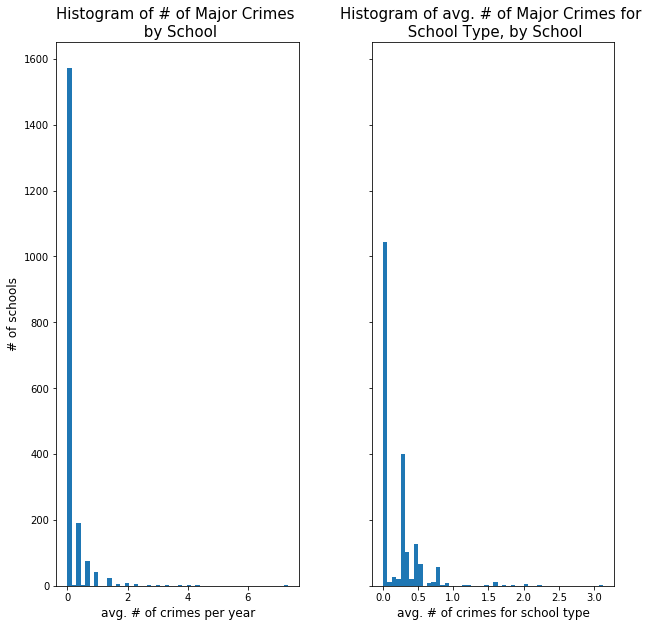

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,10))

crime.hist('avg_maj', ax=ax1, bins=50)

ax1.set_ylabel('# of schools', fontsize=12)
ax1.set_xlabel('avg. # of crimes per year', fontsize=12)
ax1.set_title('Histogram of # of Major Crimes \n by School', fontsize=15)
ax1.grid(False)

crime.hist('avg_class_maj', ax=ax2, bins=50)

ax2.set_xlabel('avg. # of crimes for school type', fontsize=12)
ax2.set_title('Histogram of avg. # of Major Crimes for \n School Type, by School', fontsize=15)
ax2.grid(False)

# FBB the stretch of the plot (vertically long_ makes it harder to understand the structure)

#### figure 1: 
This figure includes two histograms showing the distribution of # of major crimes by school. The left plot shows the # of major crimes in each school, the right plot shows the avg. # of for each school's school TYPE (ENGroupA). Both features are taken as the average of the years available in the dataset (2013/14 - 2015/16). 

Most schools appear to have 0 or close to 0 (on avg) reported crimes. Because the dataset includes ALL DOE schools and elementary schools likely have less crime than high schools, this plot might be more interesting once we limit the data to high schools. The right plot shows a different distribution, which may show us that school type is an interesting factor to explore.

# FBB good
# task 1 10/10

# Task 2:  Merge school crime and SAT data

In [37]:
print("crime DF shape", crime.shape, "SAT DF shape", sat.shape)

crime DF shape (1931, 16) SAT DF shape (421, 5)


In [38]:
schools = sat.merge(crime, on='DBN', how="left")
schools.head(2)

,DBN,SCHOOL NAME,n,math_avg,sat_avg,Building Code,ENGroupA,RangeA,Borough Name,Latitude,Longitude,avg_maj,avg_prop,avg_vio,avg_class_maj,avg_class_prop,avg_class_vio,loc_count_maj,loc_count_prop,loc_count_vio
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,404,374.000000,M056,3C,251-500,MANHATTAN,40.713684,-73.986336,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,423,390.666667,M446,3C,251-500,MANHATTAN,40.712399,-73.984497,0.333333,0.666667,0.333333,0.296667,0.72,0.473333,0.333333,0.666667,0.333333


In [39]:
schools.shape

(421, 20)

> we're left now with 421 schools, or 22% of the crimes dataset. most of the schools in this set are likely highschools, but we cannot say that the dataset includes all high schools- only schools with reported SAT scores are included

#### out of curiousity, i'm going to plot the distributions again now that i only have high schools/schools with SAT scores

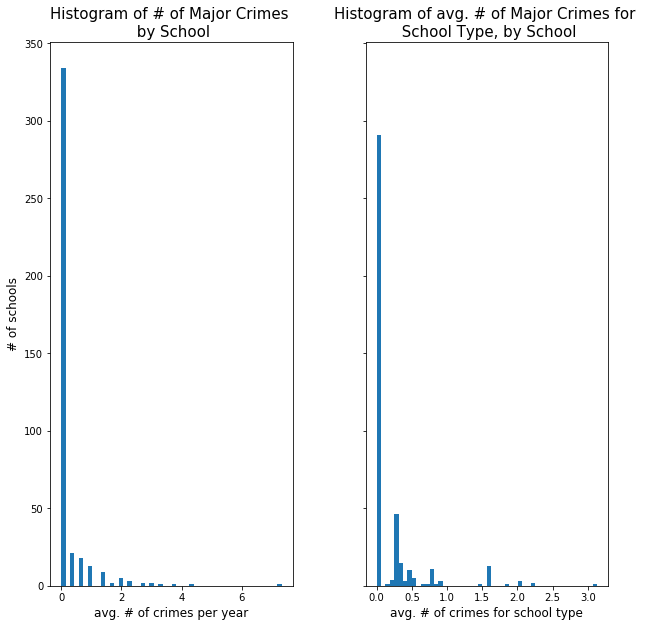

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,10))

schools.hist('avg_maj', ax=ax1, bins=50)

ax1.set_ylabel('# of schools', fontsize=12)
ax1.set_xlabel('avg. # of crimes per year', fontsize=12)
ax1.set_title('Histogram of # of Major Crimes \n by School', fontsize=15)
ax1.grid(False)

schools.hist('avg_class_maj', ax=ax2, bins=50)

ax2.set_xlabel('avg. # of crimes for school type', fontsize=12)
ax2.set_title('Histogram of avg. # of Major Crimes for \n School Type, by School', fontsize=15)
ax2.grid(False)

#### figure 2: 
Results are not much different than the previous plot! Most schools still have less than one crime reported on avg. per year. 

### fill in missing data
Note: schools with no SAT scores available were already dropped above. see explanation in task 1. 

In [41]:
#function defined in task 1

nans(schools).shape

(8, 20)

In [42]:
snans = nans(schools)
snans

,DBN,SCHOOL NAME,n,math_avg,sat_avg,Building Code,ENGroupA,RangeA,Borough Name,Latitude,Longitude,avg_maj,avg_prop,avg_vio,avg_class_maj,avg_class_prop,avg_class_vio,loc_count_maj,loc_count_prop,loc_count_vio
37,02M440,BAYARD RUSTIN EDUCATIONAL COMPLEX,59,365,370.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,03M470,LOUIS D. BRANDEIS HIGH SCHOOL,131,390,372.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,08X560,HIGH SCHOOL X560 s BRONX ACADEMY HIGH SCHOOL,9,368,390.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,12X245,NEW DAY ACADEMY,25,344,348.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216,13K336,ACADEMY OF BUSINESS AND COMMUNITY DEVELOPMENT,9,374,410.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,13K509,FREEDOM ACADEMY HIGH SCHOOL,29,390,397.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232,14K404,ACADEMY FOR YOUNG WRITERS,68,357,375.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252,15K520,PACIFIC HIGH SCHOOL,9,341,331.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> these schools can be assumed to have 0 reported crime. i will replace the NaNs with 0. 

> these schools will not have a building code, so there is no way for bme to count the total exposure to students of crime in the building, since this column came from the crime dataset

In [43]:
schools.replace(np.nan, 0, inplace=True)

In [44]:
nans(schools).shape

(0, 20)

### count by location

In [45]:
schools.shape

(421, 20)

In [46]:
schools.groupby(['Building Code']).count().describe()

,DBN,SCHOOL NAME,n,math_avg,sat_avg,ENGroupA,RangeA,Borough Name,Latitude,Longitude,avg_maj,avg_prop,avg_vio,avg_class_maj,avg_class_prop,avg_class_vio,loc_count_maj,loc_count_prop,loc_count_vio
count,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000
mean,1.625483,1.625483,1.625483,1.625483,1.625483,1.625483,1.625483,1.625483,1.625483,1.625483,1.625483,1.625483,1.625483,1.625483,1.625483,1.625483,1.625483,1.625483,1.625483
std,1.243077,1.243077,1.243077,1.243077,1.243077,1.243077,1.243077,1.243077,1.243077,1.243077,1.243077,1.243077,1.243077,1.243077,1.243077,1.243077,1.243077,1.243077,1.243077
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


> there are a total number of 259 unique building locations (give or take the 8 without building identifiers), but a total of 421 unique schools. The max amount of schools contained in one building is 8, with the mean being 1.6. 

> i have created the three features: 'loc_count_maj', 'loc_count_prop' and 'loc_count_vio, in order to address this issue. these features are the sum of each crime type for all the schools in the building. it is reasonable to assume that students have a chance of being exposed to all of the crime in their building.

# FBB good 
# task 2 10/10

# Task 3: Visualize the school related data

### plot the Math SAT score and the average of all SAT scores as a function of two crime statistics

> first let's get to the bottom of these "Avg of..N" columns ("now avg_class_..")

In [160]:
schools['ENGroupA'] = schools['ENGroupA'].astype('str')
schools['Building Code'] = schools['Building Code'].astype('str')

In [162]:
schools.sort_values('ENGroupA').tail(10)

,DBN,SCHOOL NAME,n,math_avg,sat_avg,Building Code,ENGroupA,RangeA,Borough Name,Latitude,...,avg_prop,avg_vio,avg_class_maj,avg_class_prop,avg_class_vio,loc_count_maj,loc_count_prop,loc_count_vio,lonlat,geometry
276,17K600,CLARA BARTON HIGH SCHOOL,259,-0.005699,0.245489,K600,8C,1501-1750,BROOKLYN,40.669567,...,1.373900,6.748125,1.383558,1.271927,1.676786,4.138459,1.373218,6.748389,"(-73.961962, 40.669567)",POINT (-73.961962 40.669567)
6,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,2.486261,2.367916,M022,8C,1501-1750,MANHATTAN,40.718895,...,0.785585,0.219791,1.532002,1.392108,1.651350,-0.334051,0.784796,0.219147,"(-73.97930799999999, 40.718895)",POINT (-73.97930799999999 40.718895)
33,02M420,HIGH SCHOOL FOR HEALTH PROFESSIONS AND HUMAN S...,336,0.551510,0.560985,M475,8C,1501-1750,MANHATTAN,40.732447,...,-0.391046,-0.347890,-0.444645,-0.421541,-0.425903,-0.334051,-0.392049,-0.348613,"(-73.98303100000001, 40.732447)",POINT (-73.98303100000001 40.732447)
81,04M435,MANHATTAN CENTER FOR SCIENCE AND MATHEMATICS,375,1.557581,1.272285,M435,8C,1501-1750,MANHATTAN,40.793856,...,-0.391046,-0.347890,-0.444645,-0.421541,-0.425903,-0.334051,-0.392049,-0.348613,"(-73.934028, 40.793856)",POINT (-73.934028 40.793856)
60,02M600,THE HIGH SCHOOL OF FASHION INDUSTRIES,335,0.149082,0.279906,M600,8C,1501-1750,MANHATTAN,40.745156,...,3.138846,1.071313,1.633569,1.586038,1.558086,1.653731,3.138485,1.070788,"(-73.996074, 40.745156)",POINT (-73.99607399999999 40.745156)
342,24Q600,QUEENS VOCATIONAL AND TECHNICAL HIGH SCHOOL,155,0.520554,0.354478,Q600,8C,1501-1750,QUEENS,40.742205,...,0.785585,0.219791,1.289804,1.067072,1.532650,-0.334051,0.784796,0.219147,"(-73.928219, 40.742205)",POINT (-73.928219 40.742205)
193,11X455,HARRY S TRUMAN HIGH SCHOOL,189,-0.253347,-0.328140,X455,9C,1751-2000,BRONX,40.874091,...,-0.391046,-0.347890,-0.444645,-0.421541,-0.425903,-0.334051,-0.392049,-0.348613,"(-73.833904, 40.874091)",POINT (-73.833904 40.874091)
337,24Q485,GROVER CLEVELAND HIGH SCHOOL,241,0.102648,0.016037,Q485,9C,1751-2000,QUEENS,40.711033,...,0.197270,2.490516,1.391371,1.517753,1.672546,0.659840,0.196374,2.490188,"(-73.908814, 40.711033)",POINT (-73.90881400000001 40.711033)
403,31R445,PORT RICHMOND HIGH SCHOOL,271,0.381252,0.406105,R445,9C,1751-2000,STATEN IS,40.634573,...,3.727161,5.045081,1.328869,1.422154,1.922665,1.653731,3.726908,5.045109,"(-74.141818, 40.634572999999996)",POINT (-74.141818 40.634573)
314,21K540,JOHN DEWEY HIGH SCHOOL,448,0.845592,0.308588,K540,9C,1751-2000,BROOKLYN,40.589268,...,1.962215,5.045081,3.039879,2.951737,3.690449,1.653731,1.961641,5.045109,"(-73.981738, 40.589268)",POINT (-73.98173800000001 40.589268)


> Open data website describes these columns as the "average of ... crimes for all buildings that have the same EnGroupA/Range A". is the avg for class (ENGroup) DIVIDED by school size (range A)- for a measure of crime per student, or is it the avg for schools with the same class AND size range? 

> First - ENGroup is not the same as location, as schools w the same ENGroup are in different locations. 

> Second - schools with the same class look to be the same size. 

> Third - i have slightly different figures for each school in a class for the "avg_class" features. this could be because i took an average for the available years, and some schools may not have had all three years available. some schools also seem to have 0s for this feature, when other schools in their class do not. this may be because schools not reporting crimes had 'nans' for all crime features in the original dataset. 

> i'm still not completely sure of the interpretation of these features

>>upon further inspection it looks like all schools in a particular building have the same reported crime, so the 'location' features i created are redundant 

Text(0.5,0,'# crime')

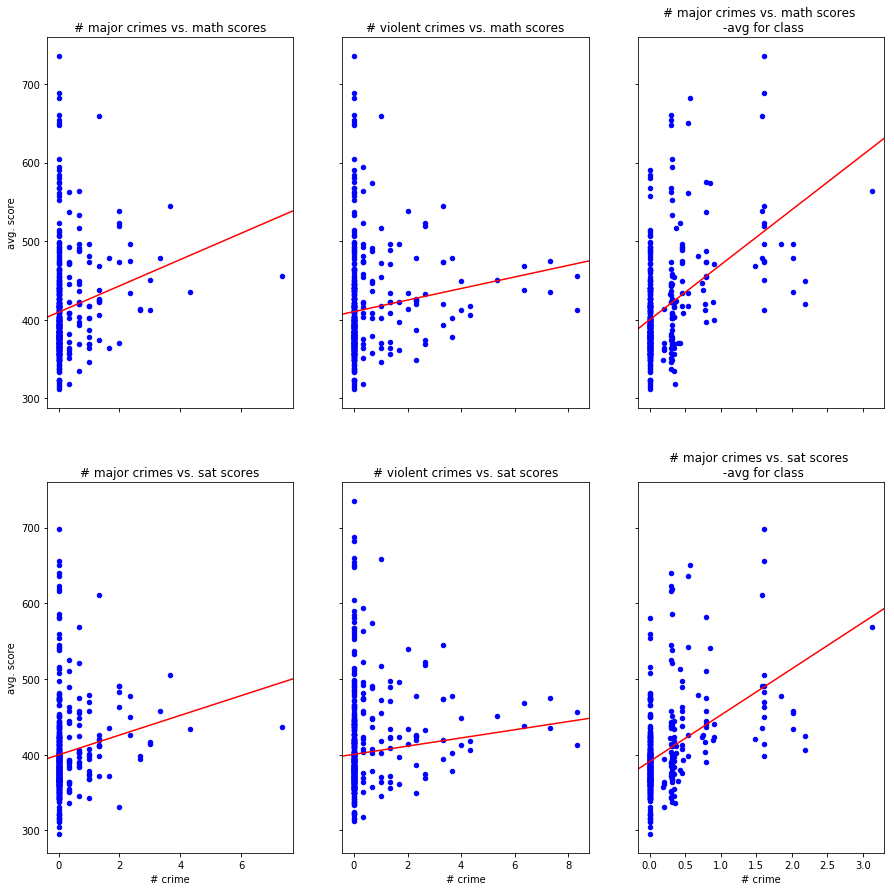

In [49]:
f, ((ax1,ax2,ax5) , (ax3,ax4,ax6)) = plt.subplots(2, 3, sharey='row', sharex='col', figsize=(15,15))

schools.plot.scatter('avg_maj', 'math_avg', ax=ax1, color='b')
ax1.set_title('# major crimes vs. math scores')
mod = smf.ols(formula='math_avg ~ avg_maj', data = schools).fit()
abline_plot(model_results=mod, ax=ax1, color='red')

schools.plot.scatter('avg_vio', 'math_avg', ax=ax2, color='b')
ax2.set_title('# violent crimes vs. math scores')
mod1 = smf.ols(formula='math_avg ~ avg_vio', data = schools).fit()
abline_plot(model_results=mod1, ax=ax2, color='red')

schools.plot.scatter('avg_class_maj', 'math_avg', ax=ax5, color='b')
ax5.set_title('# major crimes vs. math scores \n -avg for class')
mod5 = smf.ols(formula='math_avg ~ avg_class_maj', data = schools).fit()
abline_plot(model_results=mod5, ax=ax5, color='red')


schools.plot.scatter('avg_maj', 'sat_avg', ax=ax3, color='b')
ax3.set_title('# major crimes vs. sat scores')
mod2 = smf.ols(formula='sat_avg ~ avg_maj', data = schools).fit()
abline_plot(model_results=mod2, ax=ax3, color='red')

schools.plot.scatter('avg_vio', 'math_avg', ax=ax4, color='b')
ax4.set_title('# violent crimes vs. sat scores')
mod3 = smf.ols(formula='sat_avg ~ avg_vio', data = schools).fit()
abline_plot(model_results=mod3, ax=ax4, color='red')

schools.plot.scatter('avg_class_maj', 'sat_avg', ax=ax6, color='b')
ax6.set_title('# major crimes vs. sat scores \n -avg for class')
mod6 = smf.ols(formula='sat_avg ~ avg_class_maj', data = schools).fit()
abline_plot(model_results=mod6, ax=ax6, color='red')

ax1.set_ylabel('avg. score')
ax3.set_ylabel('avg. score')
ax3.set_xlabel('# crime')
ax4.set_xlabel('# crime')
ax6.set_xlabel('# crime')

### figure 3: 
Here I plotted avg. math scores and avg. sat scores (avg. for all sections) vs. # of major crimes, # of violent crimes, and avg # of major crimes for class type. The best fit lines indicate that as the # of crimes increases so do sat scores. this relationship is more pronounces in the # of major crimes plots and less so in the # of violent crimes plots. The positive correlation looks strongest in the plots vs. class avg. # major crimes. i'm still unsure about the exact interpretation of this feature, so i hesitate to draw a conclusion.

# FBB good! 


In [50]:
schools_scaled = schools
num = ['math_avg', 'sat_avg', 'avg_maj', 'avg_prop', 'avg_vio', 'avg_class_maj', 'avg_class_prop',
       'avg_class_vio', 'loc_count_maj', 'loc_count_prop', 'loc_count_vio']
for i in num: 
    schools_scaled[i] = preprocessing.scale(schools_scaled[i])

/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


## create geometry from the lat-lon coordinates and map the location of each school in the dataset

In [51]:
schools_geo = schools
schools_geo['lonlat'] = list(zip(schools_geo.Longitude, schools_geo.Latitude))

In [52]:
schools_geo['geometry'] = schools_geo[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [53]:
schools_geo = gp.GeoDataFrame(schools_geo)

In [54]:
schools_geo.crs = from_epsg(4326)

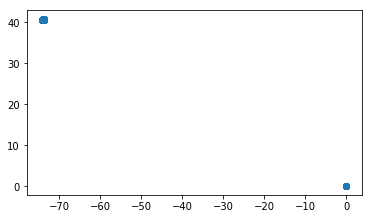

In [55]:
schools_geo.plot()

> uh oh! looks like i have at least one datapoint with the latitutde/longitude at 0, which makes no sense

# FBB you should still put the axis labels there!

In [56]:
no_geo = schools_geo[schools_geo['Latitude'] == 0]
no_geo

,DBN,SCHOOL NAME,n,math_avg,sat_avg,Building Code,ENGroupA,RangeA,Borough Name,Latitude,...,avg_prop,avg_vio,avg_class_maj,avg_class_prop,avg_class_vio,loc_count_maj,loc_count_prop,loc_count_vio,lonlat,geometry
37,02M440,BAYARD RUSTIN EDUCATIONAL COMPLEX,59,-0.748643,-0.557592,0,0,0,0,0.0,...,-0.391046,-0.34789,-0.444645,-0.421541,-0.425903,-0.334051,-0.392049,-0.348613,"(0.0, 0.0)",POINT (0 0)
72,03M470,LOUIS D. BRANDEIS HIGH SCHOOL,131,-0.361693,-0.517438,0,0,0,0,0.0,...,-0.391046,-0.34789,-0.444645,-0.421541,-0.425903,-0.334051,-0.392049,-0.348613,"(0.0, 0.0)",POINT (0 0)
105,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,-0.996291,-1.114012,M876,3C,251-500,0,0.0,...,-0.194941,-0.34789,0.289762,0.198487,0.226948,-0.334051,-0.195908,-0.348613,"(0.0, 0.0)",POINT (0 0)
134,08X560,HIGH SCHOOL X560 s BRONX ACADEMY HIGH SCHOOL,9,-0.702209,-0.213415,0,0,0,0,0.0,...,-0.391046,-0.34789,-0.444645,-0.421541,-0.425903,-0.334051,-0.392049,-0.348613,"(0.0, 0.0)",POINT (0 0)
200,12X245,NEW DAY ACADEMY,25,-1.073681,-0.930451,0,0,0,0,0.0,...,-0.391046,-0.34789,-0.444645,-0.421541,-0.425903,-0.334051,-0.392049,-0.348613,"(0.0, 0.0)",POINT (0 0)
216,13K336,ACADEMY OF BUSINESS AND COMMUNITY DEVELOPMENT,9,-0.609341,0.130763,0,0,0,0,0.0,...,-0.391046,-0.34789,-0.444645,-0.421541,-0.425903,-0.334051,-0.392049,-0.348613,"(0.0, 0.0)",POINT (0 0)
224,13K509,FREEDOM ACADEMY HIGH SCHOOL,29,-0.361693,-0.087216,0,0,0,0,0.0,...,-0.391046,-0.34789,-0.444645,-0.421541,-0.425903,-0.334051,-0.392049,-0.348613,"(0.0, 0.0)",POINT (0 0)
232,14K404,ACADEMY FOR YOUNG WRITERS,68,-0.872467,-0.477284,0,0,0,0,0.0,...,-0.391046,-0.34789,-0.444645,-0.421541,-0.425903,-0.334051,-0.392049,-0.348613,"(0.0, 0.0)",POINT (0 0)
252,15K520,PACIFIC HIGH SCHOOL,9,-1.120115,-1.234474,0,0,0,0,0.0,...,-0.391046,-0.34789,-0.444645,-0.421541,-0.425903,-0.334051,-0.392049,-0.348613,"(0.0, 0.0)",POINT (0 0)
420,79X490,PHOENIX ACADEMY,9,-0.671253,-0.637900,O308,2C,1-250,0,0.0,...,-0.391046,-0.34789,0.481176,0.246287,0.070094,-0.334051,-0.392049,-0.348613,"(0.0, 0.0)",POINT (0 0)


In [57]:
print(schools_geo.shape, no_geo.shape)

(421, 22) (10, 22)


In [58]:
schools_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 421 entries, 0 to 420
Data columns (total 22 columns):
DBN               421 non-null object
SCHOOL NAME       421 non-null object
n                 421 non-null int64
math_avg          421 non-null float64
sat_avg           421 non-null float64
Building Code     421 non-null object
ENGroupA          421 non-null object
RangeA            421 non-null object
Borough Name      421 non-null object
Latitude          421 non-null float64
Longitude         421 non-null float64
avg_maj           421 non-null float64
avg_prop          421 non-null float64
avg_vio           421 non-null float64
avg_class_maj     421 non-null float64
avg_class_prop    421 non-null float64
avg_class_vio     421 non-null float64
loc_count_maj     421 non-null float64
loc_count_prop    421 non-null float64
loc_count_vio     421 non-null float64
lonlat            421 non-null object
geometry          421 non-null object
dtypes: float64(13), int64(1), object(8

In [59]:
schools_geo = schools_geo[schools_geo['Latitude'] != 0]

In [60]:
print(schools_geo.shape, schools.shape)

(411, 22) (421, 22)


> by dropping the schools that did not have lat/long coordinates we lost 10 schools, or 2% of our dataset. these schools are still included in the 'schools' dataframe, but will not be included in any spacial analysis

> i believe address was included in some of our original data, so if we had enough time we could go back and get a point for these (if the address is provided). for now we'll move on

In [61]:
url  =  "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "boro.gz")

('boro.gz', <http.client.HTTPMessage at 0x1c23268d68>)

In [62]:
!unzip -d $PUIDATA boro.gz

Archive:  boro.gz
  inflating: /Users/katharinevoorhees/PUI2018/PUIdata/geo_export_2f38a3db-f103-4c69-8239-f3c2fc8fc0dd.dbf  
  inflating: /Users/katharinevoorhees/PUI2018/PUIdata/geo_export_2f38a3db-f103-4c69-8239-f3c2fc8fc0dd.shp  
  inflating: /Users/katharinevoorhees/PUI2018/PUIdata/geo_export_2f38a3db-f103-4c69-8239-f3c2fc8fc0dd.shx  
  inflating: /Users/katharinevoorhees/PUI2018/PUIdata/geo_export_2f38a3db-f103-4c69-8239-f3c2fc8fc0dd.prj  


In [63]:
boro = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + 
                                 "/geo_export_c13a4473-7fae-48ff-bc29-ab4a9b91c09a.shp")

Text(0.5,1,'NYC DOE Schools in Study')

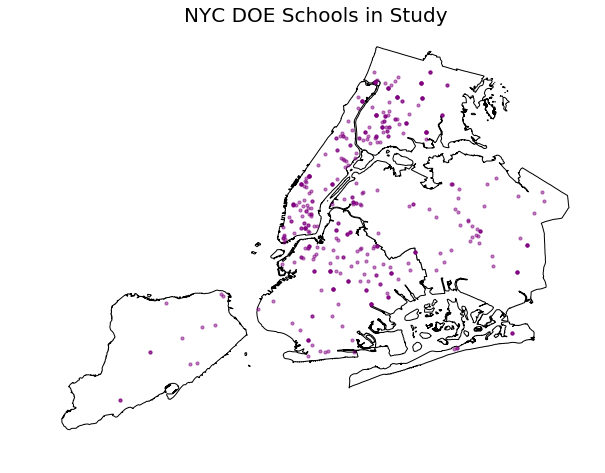

In [64]:
ax = boro.plot(facecolor="w", edgecolor="k", figsize=(10,10))
schools_geo.plot(ax=ax, color='purple', markersize=10, alpha=.5)
ax.axis('off')
plt.title('NYC DOE Schools in Study', fontsize=(20))

#### figure 4: 
This figure is a map of New York City boroughs with purple dots to represent school locations. On first look it seems like Manhattan, the South Bronx and northern Brooklyn are the most densely populated with schools. This may correspond to population density. This is important context to our analysis because our results might say more about the relationship between scores and crime on students in manhattan, the bronx and brooklyn than it does students in staten island where we don't see many schools. that said, many new york city students go to schools that are not in their own neighborhood, expecially for high school. 

# FBB task 3 10/10

# Task 4: Gather Asthma and drugs hospital discharge 

### read in the SPARCS data

!!!carefull!!! !!!only do this once!!!

In [65]:
url = 'https://health.data.ny.gov/api/views/u4ud-w55t/rows.csv?accessType=DOWNLOAD'

sparcs = pd.read_csv(url)

sparcs.head()

/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,5511.95,5582.49
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,4783.20,5162.82
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,3829.15,4056.52
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,0 to 17,147,F,White,Not Span/Hispanic,...,NaN,NaN,182357.0,NaN,NaN,0,N,Y,1108.20,1644.75
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,3418.18,3370.87


In [66]:
#make a copy so i don't have to reload the whole thing if i mess something up 

SP = sparcs

In [67]:
SP.columns

Index(['Health Service Area', 'Hospital County',
       'Operating Certificate Number', 'Facility ID', 'Facility Name',
       'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity',
       'Length of Stay', 'Type of Admission', 'Patient Disposition',
       'Discharge Year', 'CCS Diagnosis Code', 'CCS Diagnosis Description',
       'CCS Procedure Code', 'CCS Procedure Description', 'APR DRG Code',
       'APR DRG Description', 'APR MDC Code', 'APR MDC Description',
       'APR Severity of Illness Code', 'APR Severity of Illness Description',
       'APR Risk of Mortality', 'APR Medical Surgical Description',
       'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3',
       'Attending Provider License Number',
       'Operating Provider License Number', 'Other Provider License Number',
       'Birth Weight', 'Abortion Edit Indicator',
       'Emergency Department Indicator', 'Total Charges', 'Total Costs'],
      dtype='object')

In [68]:
SP.shape

(2544543, 37)

In [69]:
nyc = ['Manhattan', 'Kings', 'Queens', 'Richmond', 'Bronx']

nycsparcs = SP[SP['Hospital County'].isin(nyc)]

nycsparcs.shape

(1199520, 37)

In [70]:
nycsparcs['Hospital County'].unique()

array(['Bronx', 'Kings', 'Manhattan', 'Queens', 'Richmond'], dtype=object)

### calculate the fraction of asthma and drug related diagnoses per facility

In [71]:
nycsparcs['Facility ID'].unique().shape

(61,)

> we start with 61 nyc facilities

limiting based on diagnosis (based on hint selections) : 

In [72]:
asthma = ['Asthma', 'Respiratory failure; insufficiency; arrest (adult)', 'Respiratory distress syndrome']
             
drugs = ['Poisoning by psychotropic agents', 'Alcohol-related disorders', 'Substance-related disorders']

In [73]:
nyc_asthma = nycsparcs[nycsparcs['CCS Diagnosis Description'].isin(asthma)]

nyc_drugs = nycsparcs[nycsparcs['CCS Diagnosis Description'].isin(drugs)]

In [74]:
print(nyc_asthma['Facility ID'].unique().shape)
print(nyc_drugs['Facility ID'].unique().shape)

(55,)
(54,)


In [75]:
tot_count = nycsparcs.groupby(['Facility ID']).count()
a_count = nyc_asthma.groupby(['Facility ID']).count()
d_count = nyc_drugs.groupby(['Facility ID']).count()

tot_count = tot_count[['Facility Name']].rename(columns={'Facility Name':'tot'})
a_count = a_count[['Facility Name']].rename(columns={'Facility Name':'asthma'})
d_count = d_count[['Facility Name']].rename(columns={'Facility Name':'drugs'})

tad = tot_count.merge(a_count, left_index=True, right_index=True)
tad = tad.merge(d_count, left_index=True, right_index=True)

tad.head(3)

,tot,asthma,drugs
Facility ID,,,
1165.0,20956,1123,1279
1168.0,15889,580,1006
1169.0,43650,2105,323


In [76]:
tad['asthmaRatio'] = tad['asthma'] / tad['tot']
tad['drugsRatio'] = tad['drugs'] / tad['tot']

tad = tad[['asthmaRatio', 'drugsRatio']]

tad.head(3)

,asthmaRatio,drugsRatio
Facility ID,,
1165.0,0.053588,0.061033
1168.0,0.036503,0.063314
1169.0,0.048225,0.007400


In [77]:
tad.shape

(52, 2)

> we now have 52 facilities, we lost 15% of our nyc facilities

# FBB very nice

### find the location of each facility

In [78]:
import pandas as pd

try:
    import urllib2 as ulib
except ImportError:
    import urllib as ulib

try:
    from StringIO import BytesIO as io
except ImportError:
    from io import BytesIO as io

try:
    from urllib import urlencode as urlencode
except ImportError:
    from urllib.parse import urlencode as urlencode
    
try:
    from urllib import urlopen as urlopen
except ImportError:
    from urllib.request import urlopen as urlopen
    
try:
    from urllib2 import HTTPError as HTTPError
except ImportError:
    from urllib.error import HTTPError as HTTPError

def queryCartoDB(query, source, formatting = 'CSV'):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    
    data = urlencode({'format': formatting, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
        return response.read()
    except HTTPError as e:
        raise (ValueError('\n'.join(ast.literal_eval(e.readline())['error'])))
        
def get_data(query, sql_source):
    '''submits a query to queryCartoDB and returns a pandas dataframe
    Arguments: 
    query - string: a valid sql query string
    source - a valid sql api endpoint OPTIONAL (e.g. fb55 account)
    '''
    try:
        return pd.read_csv(io(queryCartoDB(query, source=sql_source)), sep = ',')
    except ValueError as v:
        print (str(v))


# FBB PEP8 viollation: all imports should be at the top

In [79]:
source = 'https://fb55.carto.com:443/api/v2/sql?q=' 
query = 'select * from fb55.nyc_facilities'

carto = queryCartoDB(query, source, formatting = 'CSV')

In [80]:
import io

c = pd.read_csv(io.StringIO(carto.decode('utf-8')))

In [81]:
c.columns

Index(['the_geom', 'regional_office', 'the_geom_webmercator', 'facility_id',
       'facility_name', 'short_description', 'description',
       'facility_open_date', 'facility_address_1', 'facility_address_2',
       'facility_city', 'facility_state', 'facility_zip_code',
       'facility_phone_number', 'facility_fax_number', 'facility_website',
       'facility_county_code', 'facility_county', 'regional_office_id',
       'cartodb_id', 'main_site_name', 'main_site_facility_id',
       'operating_certificate_number', 'operator_name', 'operator_address_1',
       'operator_address_2', 'operator_city', 'operator_state',
       'operator_zip_code', 'cooperator_name', 'cooperator_address',
       'cooperator_address_2', 'cooperator_city', 'cooperator_state',
       'cooperator_zip_code', 'ownership_type', 'facility_latitude',
       'facility_longitude', 'facility_location'],
      dtype='object')

In [82]:
c = c[['facility_id', 'facility_latitude', 'facility_longitude']]

In [83]:
c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 3 columns):
facility_id           1275 non-null int64
facility_latitude     1275 non-null float64
facility_longitude    1275 non-null float64
dtypes: float64(2), int64(1)
memory usage: 30.0 KB


In [84]:
c['lonlat'] = list(zip(c.facility_longitude, c.facility_latitude))

In [85]:
c['geometry'] = c[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [86]:
carto = gp.GeoDataFrame(c)

In [87]:
carto.crs = from_epsg(4326)

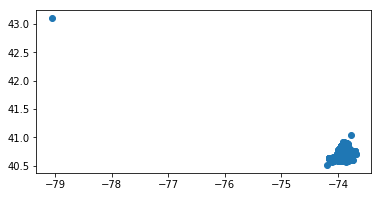

In [88]:
carto.plot()

In [89]:
carto = carto[carto['facility_latitude'] <= 42]

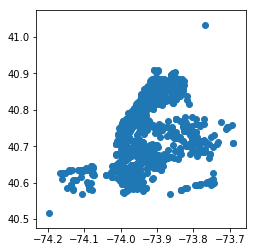

In [90]:
carto.plot()

# FBB I realize that these are working plots, and not presentation plots, but you still need the axis labels, and the contours of the city

In [91]:
health = carto.merge(tad, left_on='facility_id', right_index=True, how='right')

In [92]:
health.sort_values('facility_latitude').tail(5)

,facility_id,facility_latitude,facility_longitude,lonlat,geometry,asthmaRatio,drugsRatio
64,1186,40.880512,-73.881538,"(-73.881538, 40.880512)",POINT (-73.88153800000001 40.880512),0.028288,0.019961
57,1168,40.894569,-73.861420,"(-73.86142, 40.894569)",POINT (-73.86142 40.894569),0.036503,0.063314
1274,1302,NaN,NaN,NaN,NaN,0.030465,0.017041
1274,1632,NaN,NaN,NaN,NaN,0.050491,0.005610
1274,3376,NaN,NaN,NaN,NaN,0.050992,0.001619


In [93]:
health.dropna(inplace=True)

In [94]:
health.shape

(49, 7)

> we lost 3 facilities that didn't have locations (about 6%)

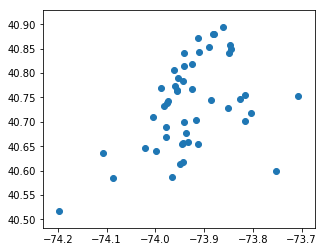

In [95]:
health.crs = from_epsg(4326)
health.plot()

# FBB task 4 9/10

# Task 5: Aggregate at the PUMA level 

### getting PUMA geodata

In [96]:
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'

PUMA = gp.GeoDataFrame.from_file(url)

Text(0.5,1,'NYC PUMAs with Schools & Medical Facilities in Study')

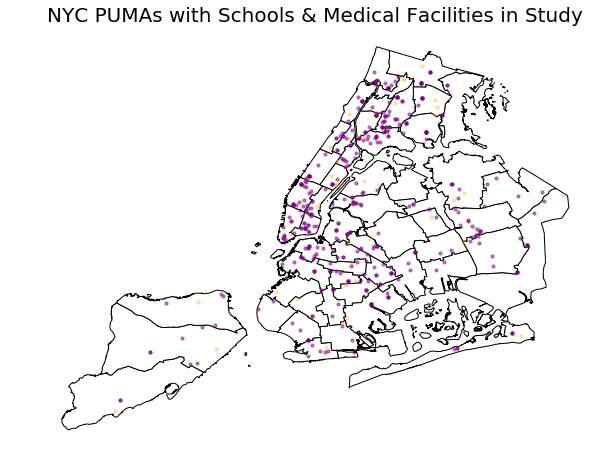

In [97]:
health.to_crs(epsg=4326)
schools_geo.to_crs(epsg=4326)

ax = PUMA.plot(facecolor="w", edgecolor="k", figsize=(10,10))
health.plot(ax=ax, color='orange', markersize=10, alpha=.3)
schools_geo.plot(ax=ax, color='purple', markersize=10, alpha=.5)
ax.axis('off')
plt.title('NYC PUMAs with Schools & Medical Facilities in Study', fontsize=(20))

#### figure 5: 
This figure depicts the borders for NYC PUMA's (Public Use Microdata Areas) as polygons. Purple points represent schools while orange points represent medical facilities. Medical facilities appear to be be distirbuted a little more evenly accross the city than schools, but again with the highest concentration in manhattan and the bronx.

# FBB good

In [98]:
schools_geo.shape

(411, 22)

### join hospital facilities and PUMA data 

In [99]:
PUMA.shape

(55, 4)

In [100]:
health.to_crs(epsg=2263, inplace=True)
PUMA.to_crs(epsg=2263, inplace=True)

In [101]:
health_puma = gp.sjoin(health, PUMA, how="right", op='intersects')
health_puma.shape

(67, 11)

In [102]:
see = nans(health_puma)
see.shape

(18, 11)

In [103]:
health_puma.puma.unique().shape

(55,)

In [104]:
puma_health = health_puma.groupby(['puma']).mean().reset_index()

In [105]:
puma_health.shape

(55, 9)

In [106]:
puma_health.head()

,puma,index_left,facility_id,facility_latitude,facility_longitude,asthmaRatio,drugsRatio,shape_area,shape_leng
0,3701,NaN,NaN,NaN,NaN,NaN,NaN,9.792852e+07,53227.144461
1,3702,57.0,1168.0,40.894569,-73.861420,0.036503,0.063314,1.889860e+08,106050.002302
2,3703,NaN,NaN,NaN,NaN,NaN,NaN,2.670137e+08,304071.257466
3,3704,195.0,2111.5,40.853482,-73.845898,0.037053,0.032269,1.062129e+08,47970.901277
4,3705,60.0,1176.0,40.853909,-73.891014,0.044207,0.202915,1.224951e+08,68657.316149


### join school data and puma

In [107]:
schools_geo.to_crs(epsg=2263, inplace=True)
school_puma = gp.sjoin(schools_geo, PUMA, how="right", op='intersects')

In [108]:
puma_school = school_puma.groupby(['puma']).mean().reset_index()

In [109]:
puma_school.shape

(55, 18)

In [110]:
alldata = puma_school.merge(puma_health, on='puma')

In [111]:
alldata.shape

(55, 26)

In [112]:
alldata.columns

Index(['puma', 'index_left_x', 'n', 'math_avg', 'sat_avg', 'Latitude',
       'Longitude', 'avg_maj', 'avg_prop', 'avg_vio', 'avg_class_maj',
       'avg_class_prop', 'avg_class_vio', 'loc_count_maj', 'loc_count_prop',
       'loc_count_vio', 'shape_area_x', 'shape_leng_x', 'index_left_y',
       'facility_id', 'facility_latitude', 'facility_longitude', 'asthmaRatio',
       'drugsRatio', 'shape_area_y', 'shape_leng_y'],
      dtype='object')

In [113]:
alldata = alldata[['puma', 'n', 'math_avg', 'sat_avg', 'avg_maj', 'avg_prop', 'avg_vio', 'avg_class_maj',
       'avg_class_prop', 'avg_class_vio', 'loc_count_maj', 'loc_count_prop',
       'loc_count_vio', 'asthmaRatio', 'drugsRatio']]
alldata.head(3)

,puma,n,math_avg,sat_avg,avg_maj,avg_prop,avg_vio,avg_class_maj,avg_class_prop,avg_class_vio,loc_count_maj,loc_count_prop,loc_count_vio,asthmaRatio,drugsRatio
0,3701,166.727273,0.46427,0.475462,-0.288874,-0.123630,-0.218872,0.232231,0.245417,0.266258,-0.288874,-0.124584,-0.219576,NaN,NaN
1,3702,60.555556,-0.53883,-0.481745,-0.334051,-0.391046,-0.347890,-0.444645,-0.421541,-0.425903,-0.334051,-0.392049,-0.348613,0.036503,0.063314
2,3703,147.200000,-0.29359,-0.195058,-0.334051,-0.391046,-0.347890,-0.444645,-0.421541,-0.425903,-0.334051,-0.392049,-0.348613,NaN,NaN


In [114]:
see = nans(alldata)
see

,puma,n,math_avg,sat_avg,avg_maj,avg_prop,avg_vio,avg_class_maj,avg_class_prop,avg_class_vio,loc_count_maj,loc_count_prop,loc_count_vio,asthmaRatio,drugsRatio
0,3701,166.727273,0.464270,0.475462,-0.288874,-0.123630,-0.218872,0.232231,0.245417,0.266258,-0.288874,-0.124584,-0.219576,NaN,NaN
2,3703,147.200000,-0.293590,-0.195058,-0.334051,-0.391046,-0.347890,-0.444645,-0.421541,-0.425903,-0.334051,-0.392049,-0.348613,NaN,NaN
5,3706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038256,0.01368
7,3708,52.250000,-0.535820,-0.495927,-0.209815,-0.292993,-0.276930,-0.356099,-0.346199,-0.343943,-0.209815,-0.293978,-0.277643,NaN,NaN
16,3807,96.285714,0.253005,0.299027,-0.050082,0.066533,-0.145147,-0.140688,-0.154904,-0.161654,-0.050082,0.065613,-0.145841,NaN,NaN
18,3809,81.294118,0.654393,0.347392,-0.275587,-0.229547,-0.264408,-0.202907,-0.203993,-0.187006,-0.275587,-0.230521,-0.265119,NaN,NaN
23,4001,60.700000,-0.270373,-0.187028,-0.184968,-0.116499,-0.205970,-0.318077,-0.321025,-0.335182,-0.184968,-0.117452,-0.206673,NaN,NaN
25,4003,35.333333,-0.423605,-0.290854,-0.251227,0.001165,-0.158663,-0.208958,-0.215320,-0.210405,-0.251227,0.000233,-0.159359,NaN,NaN
29,4007,43.500000,-0.690601,-0.712472,0.080070,-0.129572,0.006911,-0.277971,-0.297717,-0.311442,0.080070,-0.130528,0.006237,NaN,NaN
30,4008,67.285714,-0.399282,-0.528910,-0.121075,-0.166926,0.179242,-0.165615,-0.179617,-0.152166,-0.121075,-0.167888,0.178593,NaN,NaN


> there are 19 PUMAs missing either school data or health data ( mostly health data ) and one with no data

In [115]:
alldata.puma.unique().shape

(55,)

In [116]:
alldata_shape = PUMA.merge(alldata, on='puma')

In [117]:
alldata_shape.shape

(55, 18)

# FBB task 5 10/10

# Task 6: checking collinearity and covariance of the data 

/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


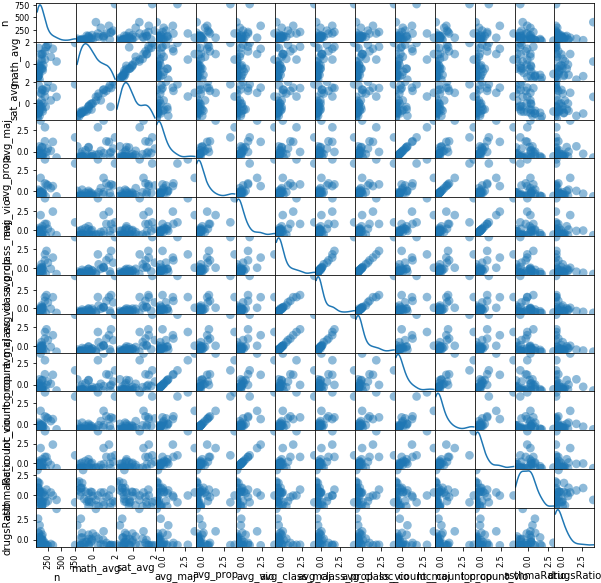

In [172]:
sfig = pd.scatter_matrix(alldata, s=300, figsize=(10, 10), diagonal='kde')


> just doing an initial exploration. looks like we have some variables that are pretty linear.

### plot SAT features against each other and assess collinearity

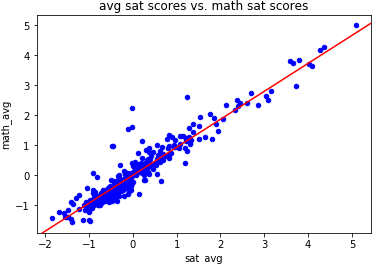

In [139]:

ax = schools.plot.scatter('sat_avg', 'math_avg', color='b')
ax.set_title('avg sat scores vs. math sat scores')
mod = smf.ols(formula='math_avg ~ sat_avg', data = alldata).fit()
abline_plot(model_results=mod, ax=ax, color='red')

plt.show()

# FBB spell out the axis labels in plain english

### figure: 
our sat score features appear to be strongly positively correlated. for modeling i think i can use just the average sat scores as the dependent variable withough impacting the results too much. 

# FBB , at this point you should identify that it is pointless to model both, cause they re very strongly collinear, and you should choose to carry on with SAT average since averaging removes some noise

### plot the SAT feature by PUMA against 3 of the crime features

In [120]:
alldata.columns

Index(['puma', 'n', 'math_avg', 'sat_avg', 'avg_maj', 'avg_prop', 'avg_vio',
       'avg_class_maj', 'avg_class_prop', 'avg_class_vio', 'loc_count_maj',
       'loc_count_prop', 'loc_count_vio', 'asthmaRatio', 'drugsRatio'],
      dtype='object')

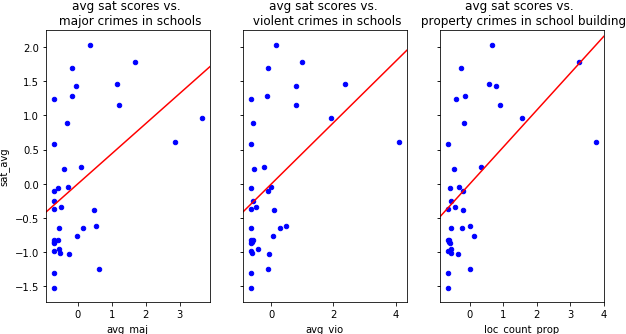

In [140]:
f, ((ax1,ax2,ax3)) = plt.subplots(1, 3, sharey=True, figsize=(10,5))

alldata.plot.scatter('avg_maj', 'sat_avg',ax=ax1, color='b')
ax1.set_title('avg sat scores vs. \n major crimes in schools')
mod1 = smf.ols(formula='sat_avg ~ avg_maj', data = alldata).fit()
abline_plot(model_results=mod1, ax=ax1, color='red')


alldata.plot.scatter('avg_vio', 'sat_avg',ax=ax2, color='b')
ax2.set_title('avg sat scores vs. \n violent crimes in schools')
mod2 = smf.ols(formula='sat_avg ~ avg_vio', data = alldata).fit()
abline_plot(model_results=mod2, ax=ax2, color='red')


alldata.plot.scatter('loc_count_prop', 'sat_avg',ax=ax3, color='b')
ax3.set_title('avg sat scores vs. \n property crimes in school building')
mod3 = smf.ols(formula='sat_avg ~ loc_count_prop', data = alldata).fit()
abline_plot(model_results=mod3, ax=ax3, color='red')

plt.show()

#### figure: 

each of these plots seems to indicate that as crime increases in a school so do sat scores. i am begging to suspect that there is an unexplored relationship between scores and school SIZE. 

### plot the SAT feature against medical data 

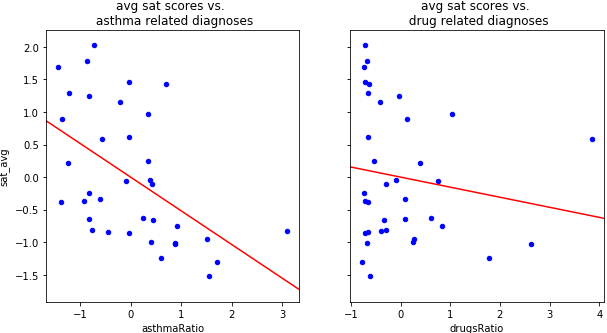

In [222]:
f, ((ax1,ax2)) = plt.subplots(1, 2, sharey=True, figsize=(10,5))

alldata.plot.scatter('asthmaRatio', 'sat_avg',ax=ax1, color='b')
ax1.set_title('avg sat scores vs. \n asthma related diagnoses')
mod1 = smf.ols(formula='sat_avg ~ asthmaRatio', data = alldata).fit()
abline_plot(model_results=mod1, ax=ax1, color='red')


alldata.plot.scatter('drugsRatio', 'sat_avg',ax=ax2, color='b')
ax2.set_title('avg sat scores vs. \n drug related diagnoses')
mod2 = smf.ols(formula='sat_avg ~ drugsRatio', data = alldata).fit()
abline_plot(model_results=mod2, ax=ax2, color='red')

plt.show()

#### figure: 

these plots seem to indicate that as both health features increase, sat scores decrease. asthma ratio seems to have a strong negative correlation with scores while the relationship with drug ratio is slightly weaker

# FBB good
# task 6 10/10

### Extra Credit: plot a covariance matrix of all feature

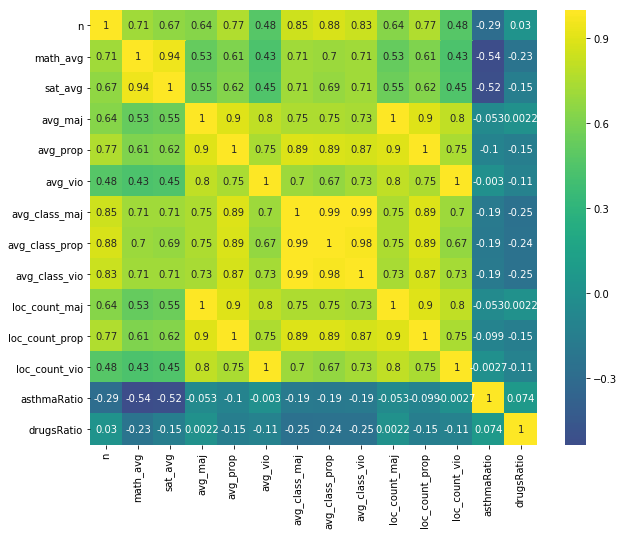

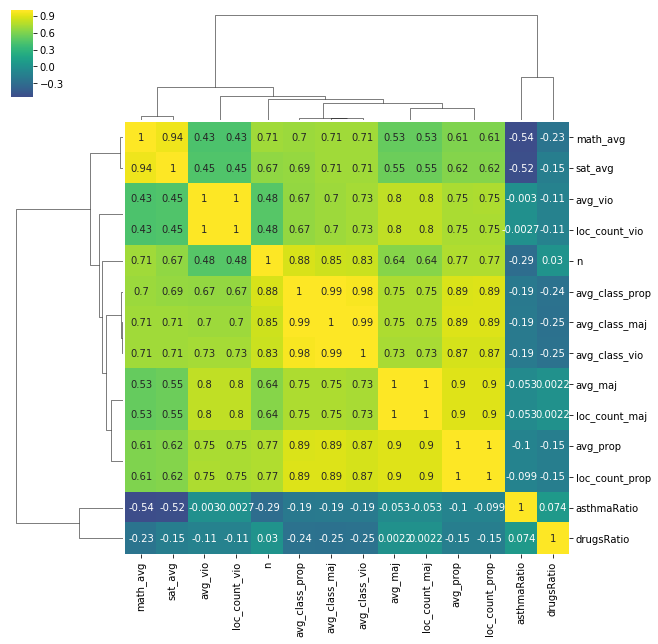

In [122]:
#heatmap table using Seaborn library with the 'seismic' colormap

fig = plt.figure(figsize = (10, 8))

ax = sns.heatmap(alldata.corr(),center= 0, cmap= 'viridis', annot= True)

#"clustermap" :

g = sns.clustermap(alldata.corr(),center= 0, cmap= 'viridis', annot= True)

#### figure : 

The plots above show correlation matrices for all variables. As features have not yet been standardized, it makes sense to look at correlation rather than covariance. We can see that like features tend to be highly correlated with eachother (with the exception of the health features). For this reason it may be best to select one measure of sat performance and one measure of crime for our modeling in order to avoid multicolinearity. 

# FBB excellent!

# Task 7: Mapping

In [123]:
alldata_shape.shape

(55, 18)

In [124]:
school_nonan = alldata_shape.dropna(subset=['sat_avg'])
health_nonan = alldata_shape.dropna(subset=['asthmaRatio'])

/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)
/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Drug Related Diagnosis')

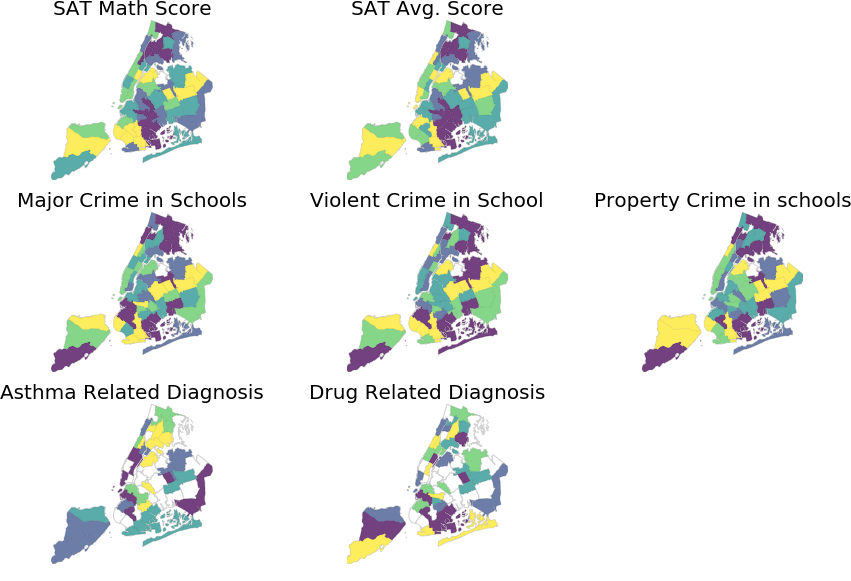

In [125]:
mpl.rcParams['savefig.pad_inches'] = 0

f, ((ax1,ax2, ax8), (ax3,ax4,ax5) , (ax6,ax7, ax9)) = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(15,10), frameon=False)

ax1.autoscale(tight=True)
ax2.autoscale(tight=True)
ax3.autoscale(tight=True)
ax4.autoscale(tight=True)
ax5.autoscale(tight=True)
ax6.autoscale(tight=True)
ax7.autoscale(tight=True)
ax8.autoscale(tight=True)
ax9.autoscale(tight=True)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')
ax6.axis('off')
ax7.axis('off')
ax8.axis('off')
ax9.axis('off')

PUMA.plot(facecolor="w", edgecolor="lightgrey", ax=ax1, figsize=(10,10))
PUMA.plot(facecolor="w", edgecolor="lightgrey", ax=ax2,  figsize=(10,10))
school_nonan.plot(column='math_avg', cmap='viridis',alpha=.75,linewidth=0.1,scheme= 'quantiles',ax=ax1, legend=False, k=5)
school_nonan.plot(column='sat_avg', cmap='viridis',alpha=.75,linewidth=0.1,scheme= 'quantiles',ax=ax2, legend=False, k=5)
ax1.set_title('SAT Math Score',fontsize=(20))
ax2.set_title('SAT Avg. Score' ,fontsize=(20))


PUMA.plot(facecolor="w", edgecolor="lightgrey", ax=ax3, figsize=(10,10))
PUMA.plot(facecolor="w", edgecolor="lightgrey", ax=ax4, figsize=(10,10))
PUMA.plot(facecolor="w", edgecolor="lightgrey", ax=ax5, figsize=(10,10))
school_nonan.plot(column='avg_maj', cmap='viridis',alpha=.75,linewidth=0.1,scheme= 'quantiles',ax=ax3, legend=False, k=5)
school_nonan.plot(column='avg_vio', cmap='viridis',alpha=.75,linewidth=0.1,scheme= 'quantiles',ax=ax4, legend=False, k=5)
school_nonan.plot(column='avg_prop', cmap='viridis',alpha=.75,linewidth=0.1,scheme= 'quantiles',ax=ax5, legend=False, k=5)
ax3.set_title('Major Crime in Schools',fontsize=(20))
ax4.set_title('Violent Crime in School' ,fontsize=(20))
ax5.set_title('Property Crime in schools',fontsize=(20))


PUMA.plot(facecolor='w', edgecolor="lightgrey", ax=ax6, figsize=(10,10))
PUMA.plot(facecolor="w", edgecolor="lightgrey", ax=ax7, figsize=(10,10))
health_nonan.plot(column='asthmaRatio', cmap='viridis',alpha=.75,linewidth=0.1,scheme= 'quantiles',ax=ax6, legend=False, k=5)
health_nonan.plot(column='drugsRatio', cmap='viridis',alpha=.75,linewidth=0.1,scheme= 'quantiles',ax=ax7, legend=False, k=5)
ax6.set_title('Asthma Related Diagnosis',fontsize=(20))
ax7.set_title('Drug Related Diagnosis' ,fontsize=(20))


#### figure:
the figure above plots our variables as cloropleths of nyc pumas. yellow represents the highest #s in each plot and purple the lowest. all features are taken as an average by puma. 

high SAT scores seem concentrated in areas of queens, south brooklyn and staten island. high sat scores seen to overlap some of the pumas with high crime.

major crime and violent crime look to be high in many of the same areas, while property crimes in schools seem to be concentrated in slightly different areas. 

high rates of asthma seem clustered in a couple of different areas, including the bronx, while drug diagnosis are more spread out. 

it should be noted that many pumas are missing from the health dataset and some from the school dataset (in white), because i dropped nans for each. (i'm not sure that this seems right for the health data since on the map in part 5 they looked pretty well distributed over the city, maybe i will retry my join)

# FBB task 7 10/10

# Task 8: start with linear modeling

>first - let's standardize our features!

In [126]:
alldata_scaled = alldata
alldata_scaled.dropna(inplace=True)
num = ['math_avg', 'sat_avg', 'avg_maj', 'avg_prop', 'avg_vio', 'avg_class_maj', 'avg_class_prop',
       'avg_class_vio', 'loc_count_maj', 'loc_count_prop', 'loc_count_vio', 'asthmaRatio', 'drugsRatio']
for i in num: 
    alldata_scaled[i] = preprocessing.scale(alldata_scaled[i])

In [127]:
alldata_scaled.shape

(36, 15)

> i kept pumas with missing data for mapping, but now i will drop nans. we lose 19 pumas here which is 35% of all pumas - a significant loss of data

### create a multivariate-linear model using only the crime in school features, but using all 10 of them, predicting the chosen SAT feature 

In [223]:
mod = smf.ols(formula='sat_avg ~ avg_maj + avg_prop + avg_vio + avg_class_maj + avg_class_prop \
              + avg_class_vio + loc_count_maj + loc_count_prop + loc_count_vio', data = alldata_scaled).fit()

mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                sat_avg   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     4.041
Date:                Mon, 17 Dec 2018   Prob (F-statistic):            0.00355
Time:                        20:12:38   Log-Likelihood:                -38.513
No. Observations:                  36   AIC:                             93.03
Df Residuals:                      28   BIC:                             105.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2.082e-17      0.133  -1.56e-16      1.000      -0.273       0.273
avg_maj            0.1664      0.170      0.980      0.335      -0.181       0.514
avg_prop          -1.0660     17.555     -0.061      0.952     -37.026      34.894
avg_vio           -0.7052     14.896     -0.047      0.963     -31.218      29.808
avg_class_maj      2.8077      4.530      0.620      0.540      -6.471      12.086
avg_class_prop    -0.4858      1.380     -0.352      0.727      -3.312       2.341
avg_class_vio     -1.4123      5.176     -0.273      0.787     -12.014       9.190
loc_count_maj      0.1664      0.170      0.980      0.335      -0.181       0.514
loc_count_prop     0.5740     17.569      0.033      0.974     -35.414      36.562
loc_count_vio      0.6800     14.768      0.046      0.964     -29.570      30.931
==============================================================================
Omnibus:                        7.358   Durbin-Watson:                   1.308
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                6.220
Skew:                           0.990   Prob(JB):                       0.0446
Kurtosis:                       3.472   Cond. No.                     3.45e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.24e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### model: 

this model has a relatively high r-squared (explaining 50% of the variation in sat scores) but a much lower adjusted r-squared, which accounts for the possibility of overfitting. i know from task 6 that there is a lot of multicolinearity here as the school crime related features are all strongly positively correlated with one another. the model summary does not indicate that any of these features are statistically significant. the confidence interval for each feature spans from negative to positive, so it it hard to even determine the direction of the relationship. 

# FBB very good

### add drugs and asthma discharge data and create a new multilinear model

In [224]:
mod1 = smf.ols(formula='sat_avg ~ avg_maj + avg_prop + avg_vio + avg_class_maj + avg_class_prop \
              + avg_class_vio + loc_count_maj + loc_count_prop + loc_count_vio + asthmaRatio + drugsRatio', 
               data = alldata_scaled).fit()

mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                sat_avg   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     5.534
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           0.000282
Time:                        20:12:43   Log-Likelihood:                -31.821
No. Observations:                  36   AIC:                             83.64
Df Residuals:                      26   BIC:                             99.48
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2.082e-17      0.115  -1.81e-16      1.000      -0.236       0.236
avg_maj            0.1133      0.152      0.747      0.462      -0.199       0.425
avg_prop          -2.9551     15.195     -0.194      0.847     -34.190      28.279
avg_vio           -2.2519     12.895     -0.175      0.863     -28.757      24.253
avg_class_maj      2.6404      3.972      0.665      0.512      -5.524      10.805
avg_class_prop    -0.4454      1.194     -0.373      0.712      -2.900       2.009
avg_class_vio     -1.4298      4.534     -0.315      0.755     -10.750       7.890
loc_count_maj      0.1133      0.152      0.747      0.462      -0.199       0.425
loc_count_prop     2.5173     15.206      0.166      0.870     -28.740      33.774
loc_count_vio      2.3700     12.781      0.185      0.854     -23.902      28.642
asthmaRatio       -0.4081      0.119     -3.421      0.002      -0.653      -0.163
drugsRatio         0.0279      0.124      0.224      0.824      -0.228       0.284
==============================================================================
Omnibus:                        3.660   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.160   Jarque-Bera (JB):                2.850
Skew:                           0.688   Prob(JB):                        0.241
Kurtosis:                       3.073   Cond. No.                     4.45e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.36e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### model: 

adding the ashthma and drugs features seems to improve our model. the r-squared of this model is .66 with an adjusted r-squared of .54 - indicating that this model is able to account for over half of the variation in our dependent variable. the ratio of health center discharges with an ashtma related diagnosis to total discharges seems to be a stastically significant indicator of lower sat scores, with a p-value of .002.

In [944]:
alldata.columns

Index(['puma', 'n', 'math_avg', 'sat_avg', 'avg_maj', 'avg_prop', 'avg_vio',
       'avg_class_maj', 'avg_class_prop', 'avg_class_vio', 'loc_count_maj',
       'loc_count_prop', 'loc_count_vio', 'asthmaRatio', 'drugsRatio'],
      dtype='object')

# FBB task 8 10/10

# Task 9: compare the linear models

#### likelihood ratio test: 

In [225]:
mod1.compare_lr_test(mod)

(13.384328407142497, 0.0012405949654742984, 2.0)

#### discussion:

according to the stats models website (https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.compare_lr_test.html)
, these are the returns i am looking at: 

#### Returns:	
lr_stat (float) – likelihood ratio, chisquare distributed with df_diff degrees of freedom

p_value (float) – p-value of the test statistic

df_diff (int) – degrees of freedom of the restriction, i.e. difference in df between models

according to this article: 
http://rnowling.github.io/machine/learning/2017/10/07/likelihood-ratio-test.html
"The Likelihood-Ratio Test can be used to determine if the addition of the features to a LR model result in a statistically-significant improvement in the fit of the model."

... so basically this test is telling me whether my second model, which includes the asthma and drugs data is a statistically-significantly better model than my first, which only included the school crime features.

with a p value less than .01, i can say the model with the health data is statistically significantly better than our first model with just the school features. we also see an improvement in the r squared with the second model, and a stasticially significant coefficient for one of the features. 





# FBB task 9 10/10

# Task 10: random forest regression on school-related data only

### create a random forest model using only the crime in school data, but using all 10 crime in school features

In [137]:
alldata_scaled.columns

Index(['puma', 'n', 'math_avg', 'sat_avg', 'avg_maj', 'avg_prop', 'avg_vio',
       'avg_class_maj', 'avg_class_prop', 'avg_class_vio', 'loc_count_maj',
       'loc_count_prop', 'loc_count_vio', 'asthmaRatio', 'drugsRatio'],
      dtype='object')

In [185]:
X = alldata_scaled[['avg_maj', 'avg_prop', 'avg_vio',
       'avg_class_maj', 'avg_class_prop', 'avg_class_vio', 'loc_count_maj',
       'loc_count_prop', 'loc_count_vio']]

y = alldata_scaled [['sat_avg']]

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)


# Supervised transformation based on random forests
rf = rfr(max_depth=3, n_estimators=100)
rf.fit(X_train, y_train)

/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [188]:
rf.score(X_test, y_test)

0.45645123472103416

In [189]:
y_pred = rf.predict(X_test)

In [190]:
from sklearn.metrics import explained_variance_score

print(explained_variance_score(y_test, y_pred))

0.539515592049118


#### discussion
 
 the explained variance score is taken as 1 - (the variance in y - the variance in predicted y)/ the the variance in y. 
 the closer to 1 this value is, the stronger the model. 

### measure the feature importance of the features in this model to select the 3 most predictive features 

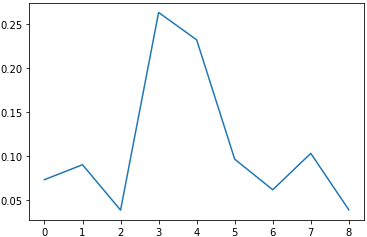

In [199]:
pl.plot((rf.feature_importances_))

In [200]:
rf.feature_importances_

array([0.07354637, 0.09048404, 0.03901311, 0.26319078, 0.23213451,
       0.09681761, 0.06210491, 0.1033593 , 0.03934938])

In [201]:
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)


    pl.figure()
    pl.title("Feature importances")
    pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices], align="center")
    pl.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    pl.xlim([-1, indices.shape[0]])
    pl.show()

In [202]:
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 3 (0.185470)
2. feature 9 (0.170428)
3. feature 4 (0.141773)
4. feature 7 (0.133204)
5. feature 1 (0.122464)
6. feature 5 (0.116904)
7. feature 10 (0.071043)
8. feature 0 (0.023090)
9. feature 6 (0.021317)


In [211]:
labels

[['avg_maj',
  'avg_prop',
  'avg_vio',
  'avg_class_maj',
  'avg_class_prop',
  'avg_class_vio',
  'loc_count_maj',
  'loc_count_prop',
  'loc_count_vio']]

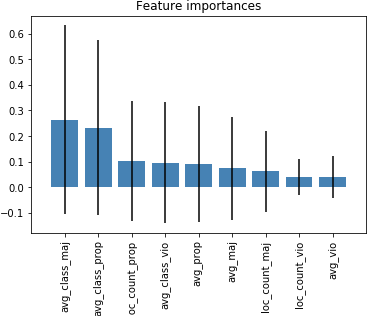

In [212]:
labels = [['avg_maj', 'avg_prop', 'avg_vio',
       'avg_class_maj', 'avg_class_prop', 'avg_class_vio', 'loc_count_maj',
       'loc_count_prop', 'loc_count_vio']]

featureImportancePlot(rf,('avg_maj', 'avg_prop', 'avg_vio',
       'avg_class_maj', 'avg_class_prop', 'avg_class_vio', 'loc_count_maj',
       'loc_count_prop', 'loc_count_vio'))

#### discusion 

i'm not entirely sure what is going wrong with the indices in my plotting, but i can tell from these results that the three most import features are identified as: 'avg_class_maj','avg_class_prop', 'loc_count_prop'.

this is an interesting result, becuase my expectation was to find that violent crime was the most important predictor, but two of the 3 most important features are measures of property crimes. 

it is also interesting that two of the 3 most important features are at the "class" level. as best as i can tell this represents the avg. crime count amount for all schools of a similar size - so perhaps school size has more to do with sat scores than crime. this would be interesting to explore in future study.

# FBB oh too bad1 you missed the uncertainties! the uncertainty (plotted is the 1-sigma uncertainty) in the feature importance indicated that all features are consistent with each other, i.e. you cannot tell from this model which is most important. Also they are consistent with 0, i.e. you an throw them away and the model is just fine. You cannot do feature importance with bad models. 



# Task 11: random forest with crime and medical features

### create a random forest model that only uses the 3 most predictive features about school crimes and the health features

In [214]:
X = alldata_scaled[['avg_class_maj', 'avg_class_prop', 'loc_count_prop', 'asthmaRatio', 'drugsRatio']]

y = alldata_scaled [['sat_avg']]

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)


# Supervised transformation based on random forests
rf = rfr(max_depth=3, n_estimators=100)
rf.fit(X_train, y_train)

/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### evaluate the performance of the model

In [216]:
rf.score(X_test, y_test)

0.5197733367722664

In [217]:
y_pred = rf.predict(X_test)

In [218]:
from sklearn.metrics import explained_variance_score

print(explained_variance_score(y_test, y_pred))

0.6155221146028365


#### discussion: 

This model performed better than our previous model with higher r-squared score and higher explained variance! 

### discuss the importance of each feature in the model

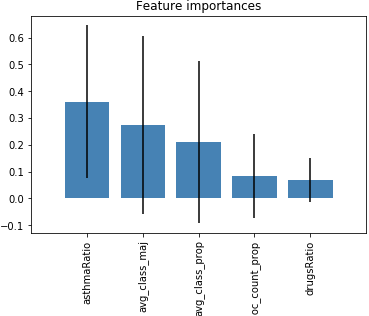

In [219]:
featureImportancePlot(rf,('avg_class_maj', 'avg_class_prop', 'loc_count_prop', 'asthmaRatio', 'drugsRatio'))

### discussion: 

asthmaRatio (asthma-related diagnoses/all diagnoses)  was found to be the most important of all features followed by avg_class_major crime (avg. # of 'major' crimes at schools of like size), avg_class_property crime (avg. # of 'property' crimes at schools of like size), and then loc_count_property crime (count of property crimes in school building) and finally drugs ratio (drug-related diagnoses/all diagnoses). 

the findings on the strength of asthma prevalence (by puma - taken as # asthma related discharges / all discharges) is an interesting topic for future study. it may be useful to next compare this asthma ratio feature to available air quality data to see if what we are observing here is possibly a negative effect of bad air quality on test scores. 


# FBB same issue with the uncertainties

## *Thank you for a great semester! I certainly did not master all the topics in this course, but coming from not knowing what a jupyter notebook was on day one to here feels pretty incredible!*

# FBB very good!

# 1 10/10
# 2 10/10
# 3 10/10
# 4 9/10
# 5 10/10
# 6 10/10
# 7 10/10
# 8 10/10
# 9 10/10
# 10 7/10
# 11 7/10

# EC - very good on the matrix
# total 100/100